In [28]:
import pandas as pd
import xarray as xr
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy.integrate import quad
import matplotlib.pyplot as plt
import numpy as np

In [3]:
path = "/home/jmindlin/BF_codes/data/DCENT_GMST_statistics.txt"

# 1) Find the header line ("Year,GMST (°C),...")
with open(path, "r", encoding="utf-8") as f:
    lines = f.readlines()

start = next(i for i, line in enumerate(lines) if line.strip().startswith("Year,"))


# 2) Read CSV from that header line onward; allow commas with spaces
df = pd.read_csv(
    path,
    skiprows=start,               # start at the header line
    engine="python",
    sep=r"\s*,\s*",               # split on commas, ignoring surrounding spaces
    comment=None
)

# 3) Clean column names to something easy to use
rename_map = {
    "Year": "year",
    "GMST (°C)": "gmst",
    "1 s.d. (°C)": "gmst_sd",
    "GMST non infilled (°C)": "gmst_noninf",
    "1 s.d. (°C; non  infilled)": "gmst_noninf_sd",
}
# in case of double spaces etc., normalize header keys first
df.columns = [re.sub(r"\s+", " ", c).strip() for c in df.columns]
rename_map_norm = {re.sub(r"\s+", " ", k).strip(): v for k, v in rename_map.items()}
df = df.rename(columns=rename_map_norm)

# 4) Ensure numeric dtypes
for c in ["year", "gmst", "gmst_sd", "gmst_noninf", "gmst_noninf_sd"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# 5) Convert to xarray (optional)
ds = xr.Dataset(
    {
        "GMST": (["year"], df["gmst"].values),
        "GMST_sd": (["year"], df["gmst_sd"].values),
        "GMST_non_infilled": (["year"], df["gmst_noninf"].values),
        "GMST_non_infilled_sd": (["year"], df["gmst_noninf_sd"].values),
    },
    coords={"year": df["year"].values.astype(int)},
)
ds_full = ds.copy()
ds = ds - ds.sel(year=slice('1951','1980')).mean(dim='year')


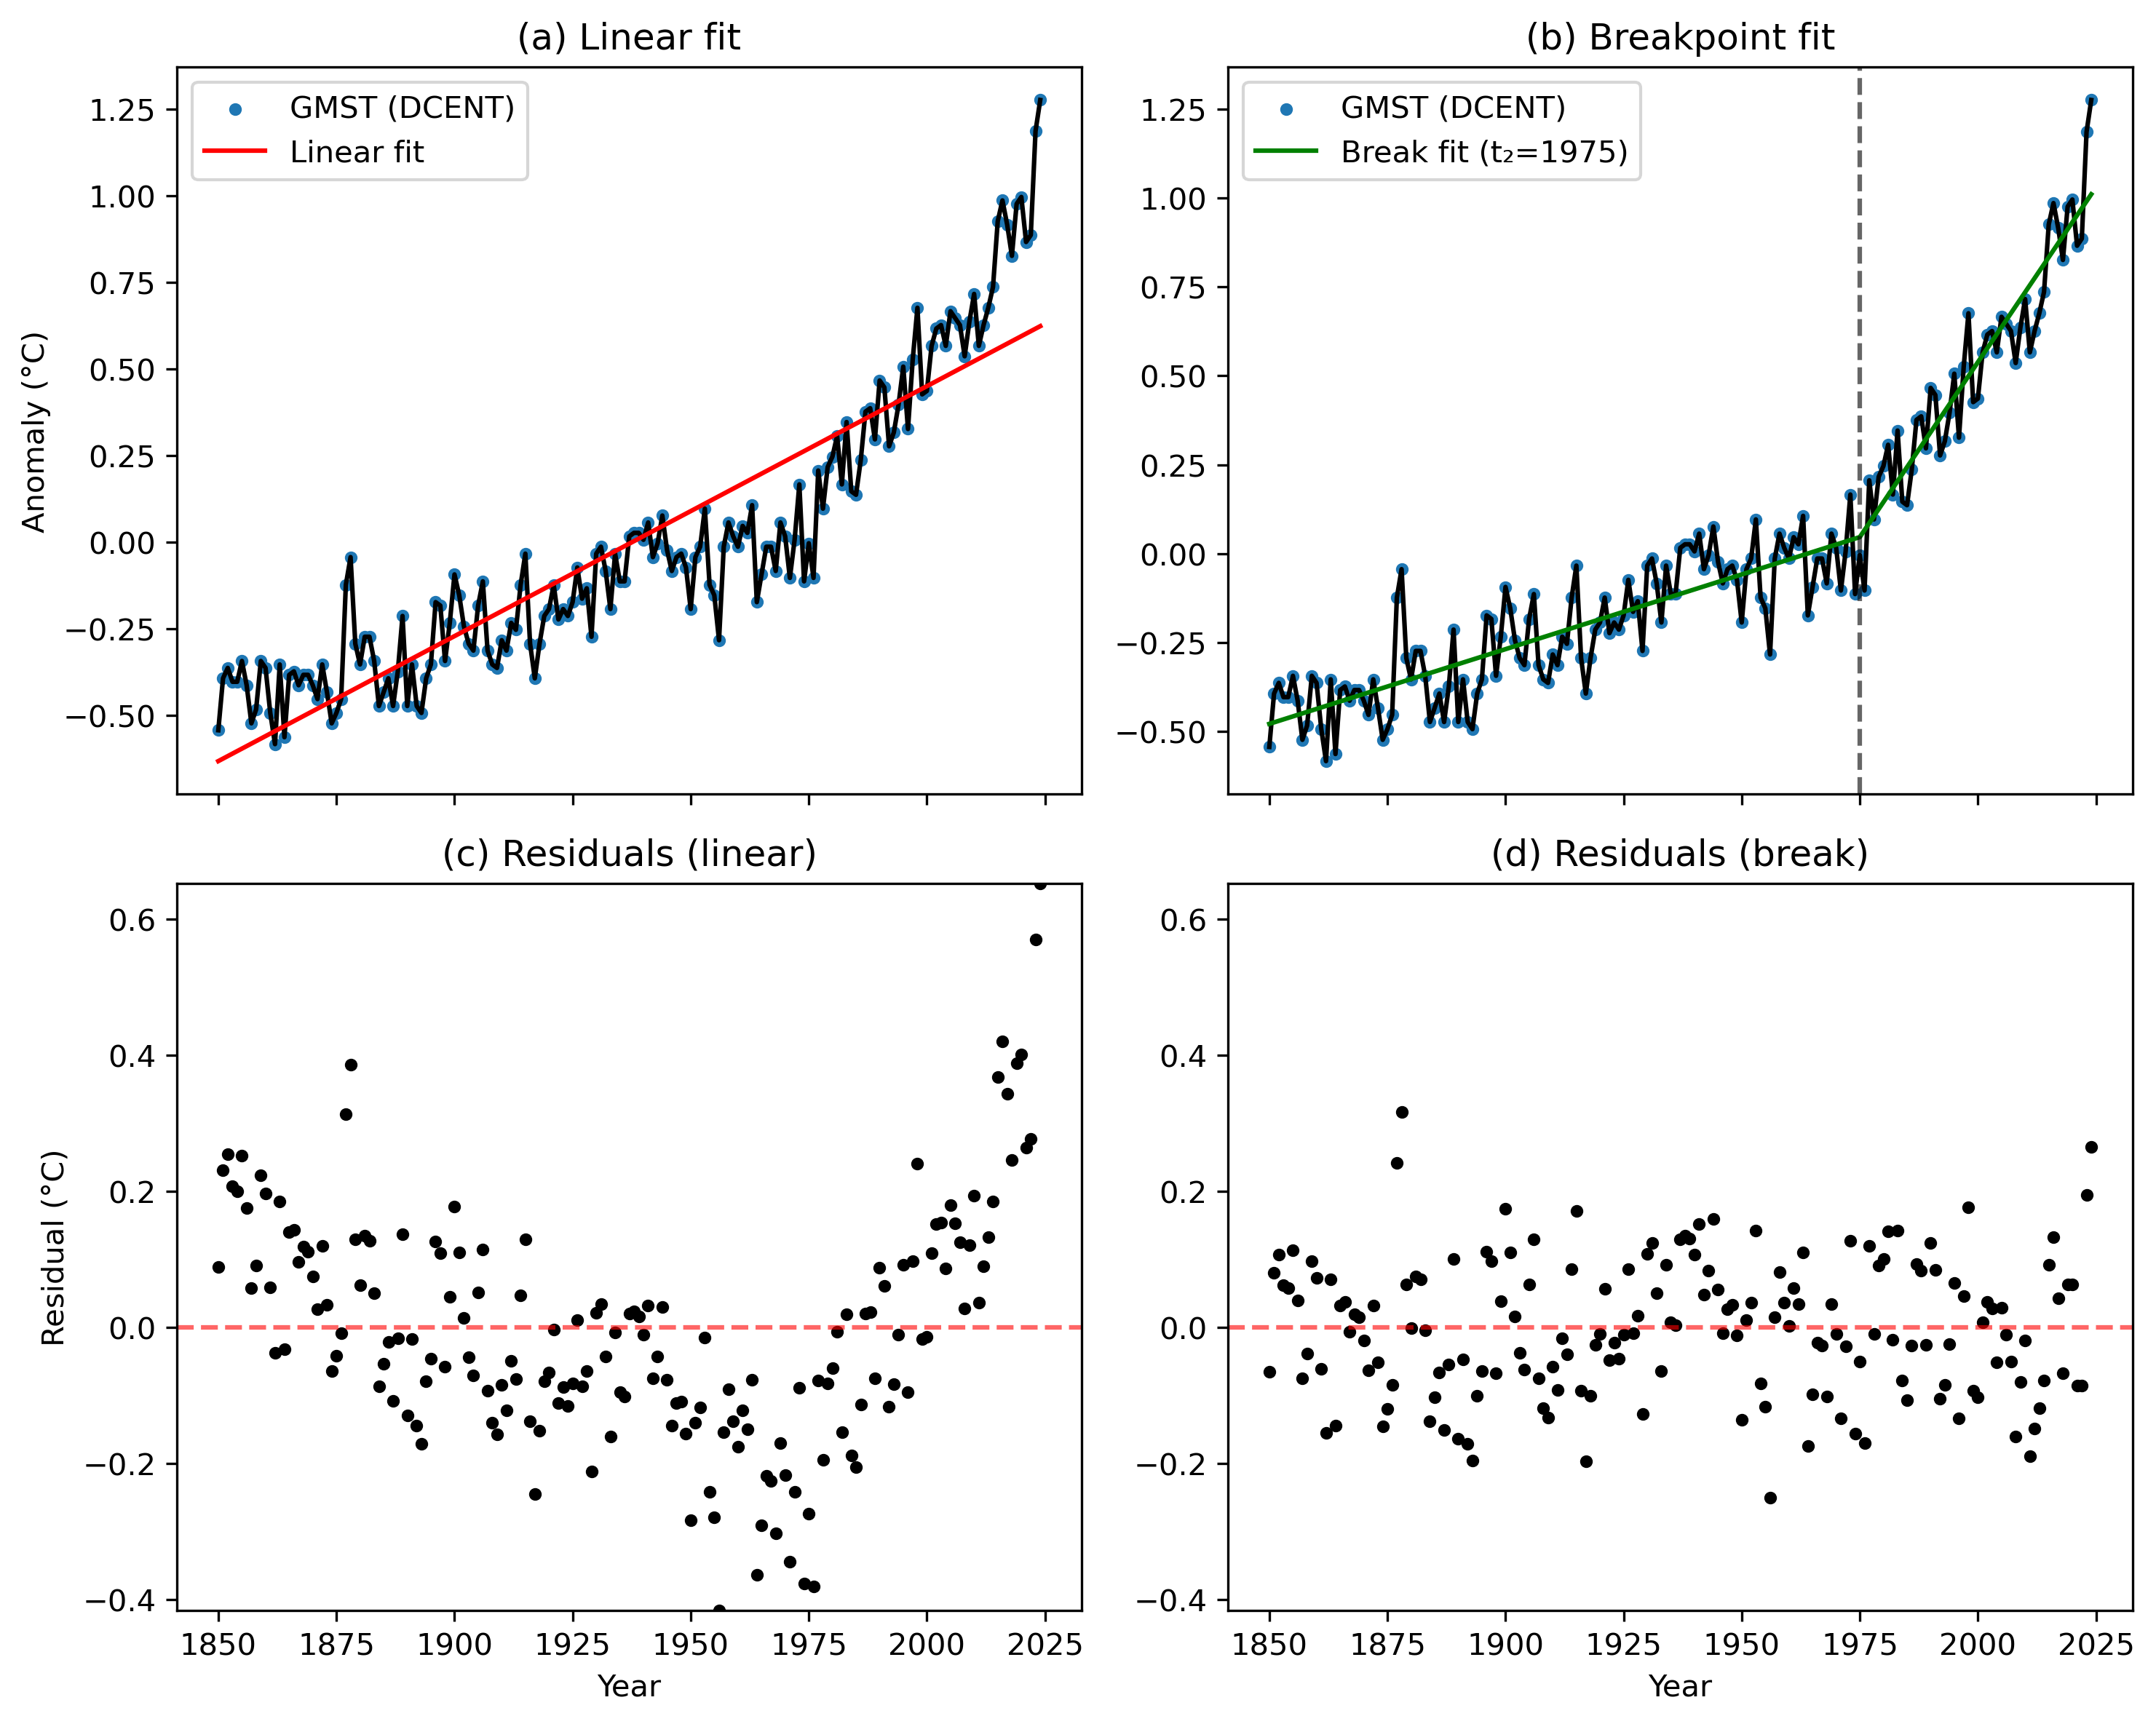

In [4]:
# --- Load GISTEMP annual global mean anomalies (°C, 1951–1980 baseline) ---
t = ds.year
y = ds['GMST'].values
n = len(y)

# --- Linear model ---
X_lin = np.column_stack([np.ones(n), t])
beta_lin, *_ = np.linalg.lstsq(X_lin, y, rcond=None)
yhat_lin = X_lin @ beta_lin
resid_lin = y - yhat_lin

# --- Breakpoint model ---
def fit_break(t2):
    left = (t <= t2).astype(float)
    right = 1.0 - left
    X = np.column_stack([np.ones(n), (t - t2)*left, (t - t2)*right])
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)
    return X @ beta, beta

# Search break by SSE
cands = t[1:-1]
best = min(((np.sum((y - fit_break(t2)[0])**2), t2) for t2 in cands), key=lambda x: x[0])
t2_hat = best[1]
yhat_brk, beta_brk = fit_break(t2_hat)
resid_brk = y - yhat_brk


# --- Plot with shared scales ---
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, dpi=300)

# (a) linear fit
axes[0,0].scatter(t, y, s=10, label="GMST (DCENT)")
axes[0,0].plot(t, y,color='k')
axes[0,0].plot(t, yhat_lin, 'r', label="Linear fit")
axes[0,0].set_title("(a) Linear fit")
axes[0,0].set_ylabel("Anomaly (°C)")
axes[0,0].legend()

# (b) breakpoint fit
axes[0,1].scatter(t, y, s=10, label="GMST (DCENT)")
axes[0,1].plot(t, y, color='k')
axes[0,1].plot(t, yhat_brk, 'g', label=f"Break fit (t₂={int(t2_hat)})")
axes[0,1].axvline(t2_hat, ls="--", color="k", alpha=0.6)
axes[0,1].set_title("(b) Breakpoint fit")
axes[0,1].legend()

# Residual y-limits (same for c & d)
resid_min = min(resid_lin.min(), resid_brk.min())
resid_max = max(resid_lin.max(), resid_brk.max())

# (c) residuals linear
axes[1,0].scatter(t, resid_lin, s=10,color='k')
axes[1,0].axhline(0, ls="--", color="r", alpha=0.6)
axes[1,0].set_ylim(resid_min, resid_max)
axes[1,0].set_title("(c) Residuals (linear)")
axes[1,0].set_xlabel("Year")
axes[1,0].set_ylabel("Residual (°C)")

# (d) residuals break
axes[1,1].scatter(t, resid_brk, s=10, color='k')
axes[1,1].axhline(0, ls="--", color="r", alpha=0.6)
axes[1,1].set_ylim(resid_min, resid_max)
axes[1,1].set_title("(d) Residuals (break)")
axes[1,1].set_xlabel("Year")

plt.tight_layout()
plt.show()


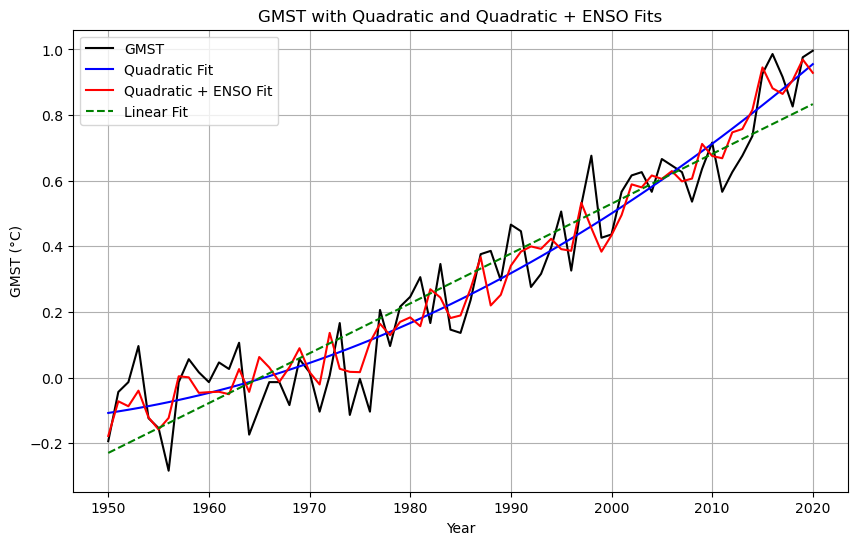

In [6]:

# --- Load GISTEMP annual global mean anomalies (°C, 1951–1980 baseline) ---
t = ds.sel(year=slice('1950','2020')).year
y = ds['GMST'].sel(year=slice('1950','2020')).values

### Linear model
X_lin = np.column_stack([np.ones(len(y)), t])
beta_lin, *_ = np.linalg.lstsq(X_lin, y, rcond=None)
yhat_lin = X_lin @ beta_lin
rss_lin = np.sum((y - yhat_lin)**2)

### Quadratic model
X_quad = np.column_stack([np.ones(len(y)), t, t**2])
beta_quad, *_ = np.linalg.lstsq(X_quad, y, rcond=None)
yhat_quad = X_quad @ beta_quad
rss_quad = np.sum((y - yhat_quad)**2)

oni_path = '/home/jmindlin/BF_codes/data/oni_data.txt'

def load_oni_xarray(src):
    df = np.loadtxt(src,skiprows=1, max_rows=76)
    oni = np.concatenate([df[i,1:13].flatten() for i in range(df.shape[0]-1)])
    t = pd.date_range('1950-01-01', '2025-01-01', freq='ME')
    da = xr.DataArray(oni,dims=["time"],coords={"time": t}, name="oni",attrs={    "units": "degC",    "source": 'NOAA'})
    return da

oni = load_oni_xarray(oni_path)

# Select common period
oni_annual = oni.sel(time=slice('1950','2020')).groupby('time.year').mean(dim='time')

### Quadratic + ENSO model
X_quad_enso = np.column_stack([np.ones(len(y)), t, t**2, oni_annual.values])
beta_quad_enso, *_ = np.linalg.lstsq(X_quad_enso, y, rcond=None)
yhat_quad_enso = X_quad_enso @ beta_quad_enso
resid_quad_enso = y - yhat_quad_enso

# ### Bayes Factor comparing Quadratic and Quadratic + ENSO models
# sse1 = np.sum(resid_quad**2)
# sse2 = np.sum(resid_quad_enso**2)
# k1 = X_quad.shape[1]
# k2 = X_quad_enso.shape[1]
# n = len(y)
# bf = (sse1/sse2)**(n/2) * n**((k2 - k1)/2)
# print("Bayes Factor (Quadratic vs Quadratic + ENSO):", bf)


plt.figure(figsize=(10,6))
plt.plot(t, y, label='GMST', color='black')
plt.plot(t, yhat_quad, label='Quadratic Fit', color='blue')
plt.plot(t, yhat_quad_enso, label='Quadratic + ENSO Fit', color='red')
plt.plot(t, yhat_lin, label='Linear Fit', color='green', linestyle='--')
plt.xlabel('Year')
plt.ylabel('GMST (°C)')
plt.title('GMST with Quadratic and Quadratic + ENSO Fits')
plt.legend()
plt.grid()
plt.show()


In [7]:

# --- Load GISTEMP annual global mean anomalies (°C, 1951–1980 baseline) ---
t = ds.sel(year=slice('1950','2024')).year
y = ds['GMST'].sel(year=slice('1950','2024')).values

### Linear model
X_lin = np.column_stack([np.ones(len(y)), t])
yhat_lin = X_lin @ beta_lin
rss_lin = np.sum((y - yhat_lin)**2)

### Quadratic model
X_quad = np.column_stack([np.ones(len(y)), t, t**2])
yhat_quad = X_quad @ beta_quad
rss_quad = np.sum((y - yhat_quad)**2)

oni_path = '/home/jmindlin/BF_codes/data/oni_data.txt'

def load_oni_xarray(src):
    df = np.loadtxt(src,skiprows=1, max_rows=76)
    oni = np.concatenate([df[i,1:13].flatten() for i in range(df.shape[0]-1)])
    t = pd.date_range('1950-01-01', '2025-01-01', freq='ME')
    da = xr.DataArray(oni,dims=["time"],coords={"time": t}, name="oni",attrs={    "units": "degC",    "source": 'NOAA'})
    return da

oni = load_oni_xarray(oni_path)

# Select common period
oni_annual = oni.sel(time=slice('1950','2024')).groupby('time.year').mean(dim='time')

### Quadratic + ENSO model
X_quad_enso = np.column_stack([np.ones(len(y)), t, t**2, oni_annual.values])
yhat_quad_enso = X_quad_enso @ beta_quad_enso
resid_quad_enso = y - yhat_quad_enso


In [8]:
def product(x, mu, sigma, n):
    result = (1/2 + 1/2 * special.erf((x -mu[0])/ np.sqrt(2) *sigma[0]))
    for i in range(n-1):
        result * (1/2 + 1/2 * special.erf((x - mu[i+1])/ (np.sqrt(2)*sigma[i+1])))
    return result


def f(x, mu, sigma, c, n):
    out = (1/np.sqrt(2*np.pi*sigma[n]**2)) * np.exp(-((x+c - mu[n])**2/(2*sigma[n]**2))) * product(x, mu, sigma, n)
    return out


In [9]:
def pint(mu, sigma, c, n):
    return quad(f, -np.inf, np.inf, args=(mu, sigma, c, n))[0]

In [10]:
sigma = np.ones(len(yhat_lin)) * np.std(y[:30])

In [11]:
y[-2] - y[-1] 

np.float64(-0.09000000000000008)

In [12]:
c = 0.2

P_tn_linear = []
P_tn_quadratic = []
P_tn_quadratic_enso = []

for n,time_step in enumerate(range(1,len(yhat_lin)+1)):
    P_tn_linear.append(pint(yhat_lin,sigma,c,n))
    P_tn_quadratic.append(pint(yhat_quad,sigma,c,n))
    P_tn_quadratic_enso.append(pint(yhat_quad_enso,sigma,c,n))


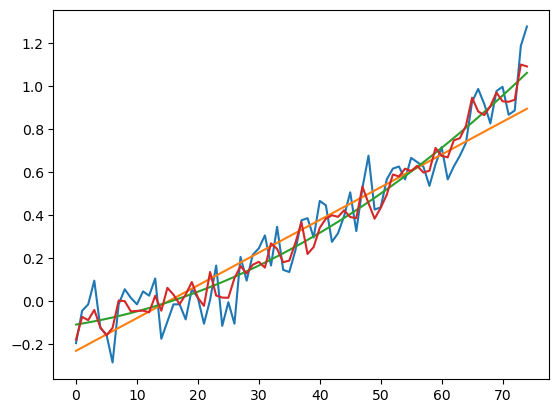

In [13]:
plt.plot(y, label='Obs')
plt.plot(yhat_lin, label='Linear trend')
plt.plot(yhat_quad, label='Quadratic trend')
plt.plot(yhat_quad_enso, label='Quadratic + ENSO trend')

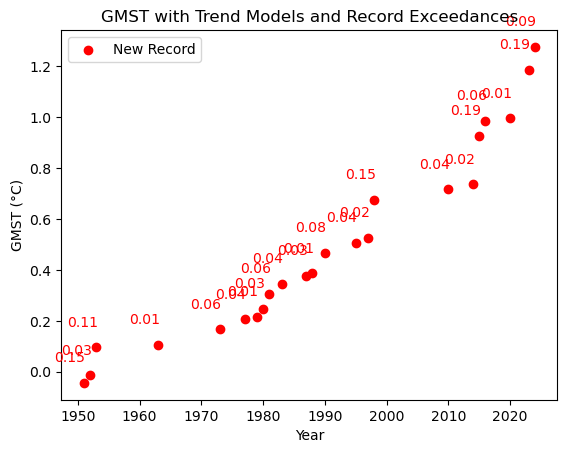

In [14]:
# From the flag of records, compute by how much the record was exceeded and plot
record_flags = y[1:] > np.maximum.accumulate(y[:-1])
record_exceedance = y[1:][record_flags] - np.maximum.accumulate(y[:-1])[record_flags]
plt.scatter(t[1:][record_flags], y[1:][record_flags], color='red', label='New Record')
for i, txt in enumerate(record_exceedance):
    plt.annotate(f"{txt:.2f}", (t[1:][record_flags][i], y[1:][record_flags][i]), textcoords="offset points", xytext=(-10,15), ha='center', color='red')
plt.xlabel('Year')
plt.ylabel('GMST (°C)')
plt.title('GMST with Trend Models and Record Exceedances')
plt.legend()



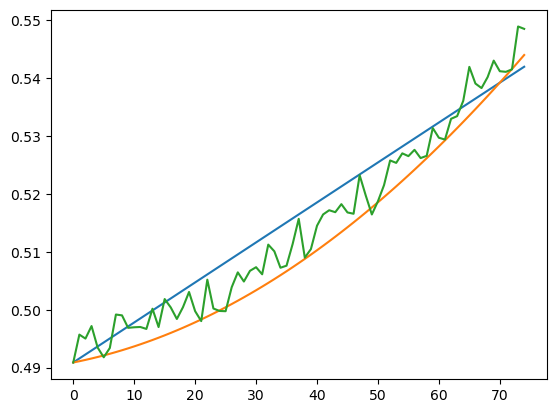

In [15]:
plt.plot(P_tn_linear, label='Linear trend')
plt.plot(P_tn_quadratic, label='Quadratic trend')
plt.plot(P_tn_quadratic_enso, label='Quadratic + ENSO trend')

In [16]:
record_flags = y[1:] > np.maximum.accumulate(y[:-1])
r_2023 = record_flags[-2] 
r_2024 = record_flags[-1]

In [17]:
### Record flags of exceedence of more than c = 0.9 °C
record_flags = y[1:] > np.maximum.accumulate(y[:-1]) + c
r_c_2023 = record_flags[-2] 
r_c_2024 = record_flags[-1]

In [18]:
def record_likelihood(P_record_model, flags):
    return np.prod([
        p if r else (1 - p)
        for p, r in zip(P_record_model[-2:], flags)
    ])

In [19]:
flags = [r_2023, r_2024]

L_linear = record_likelihood(P_tn_linear, flags)
L_quad = record_likelihood(P_tn_quadratic, flags)
L_quad_enso = record_likelihood(P_tn_quadratic_enso, flags)

In [20]:
BF_quad_vs_lin = L_quad / L_linear
BF_quadenso_vs_lin = L_quad_enso / L_linear
BF_quadenso_vs_quad = L_quad_enso / L_quad

In [21]:
BF_quad_vs_lin

np.float64(1.0065221525980994)

In [22]:
BF_quadenso_vs_lin

np.float64(1.026362136696944)

In [23]:
BF_quadenso_vs_quad

np.float64(1.019711423188881)

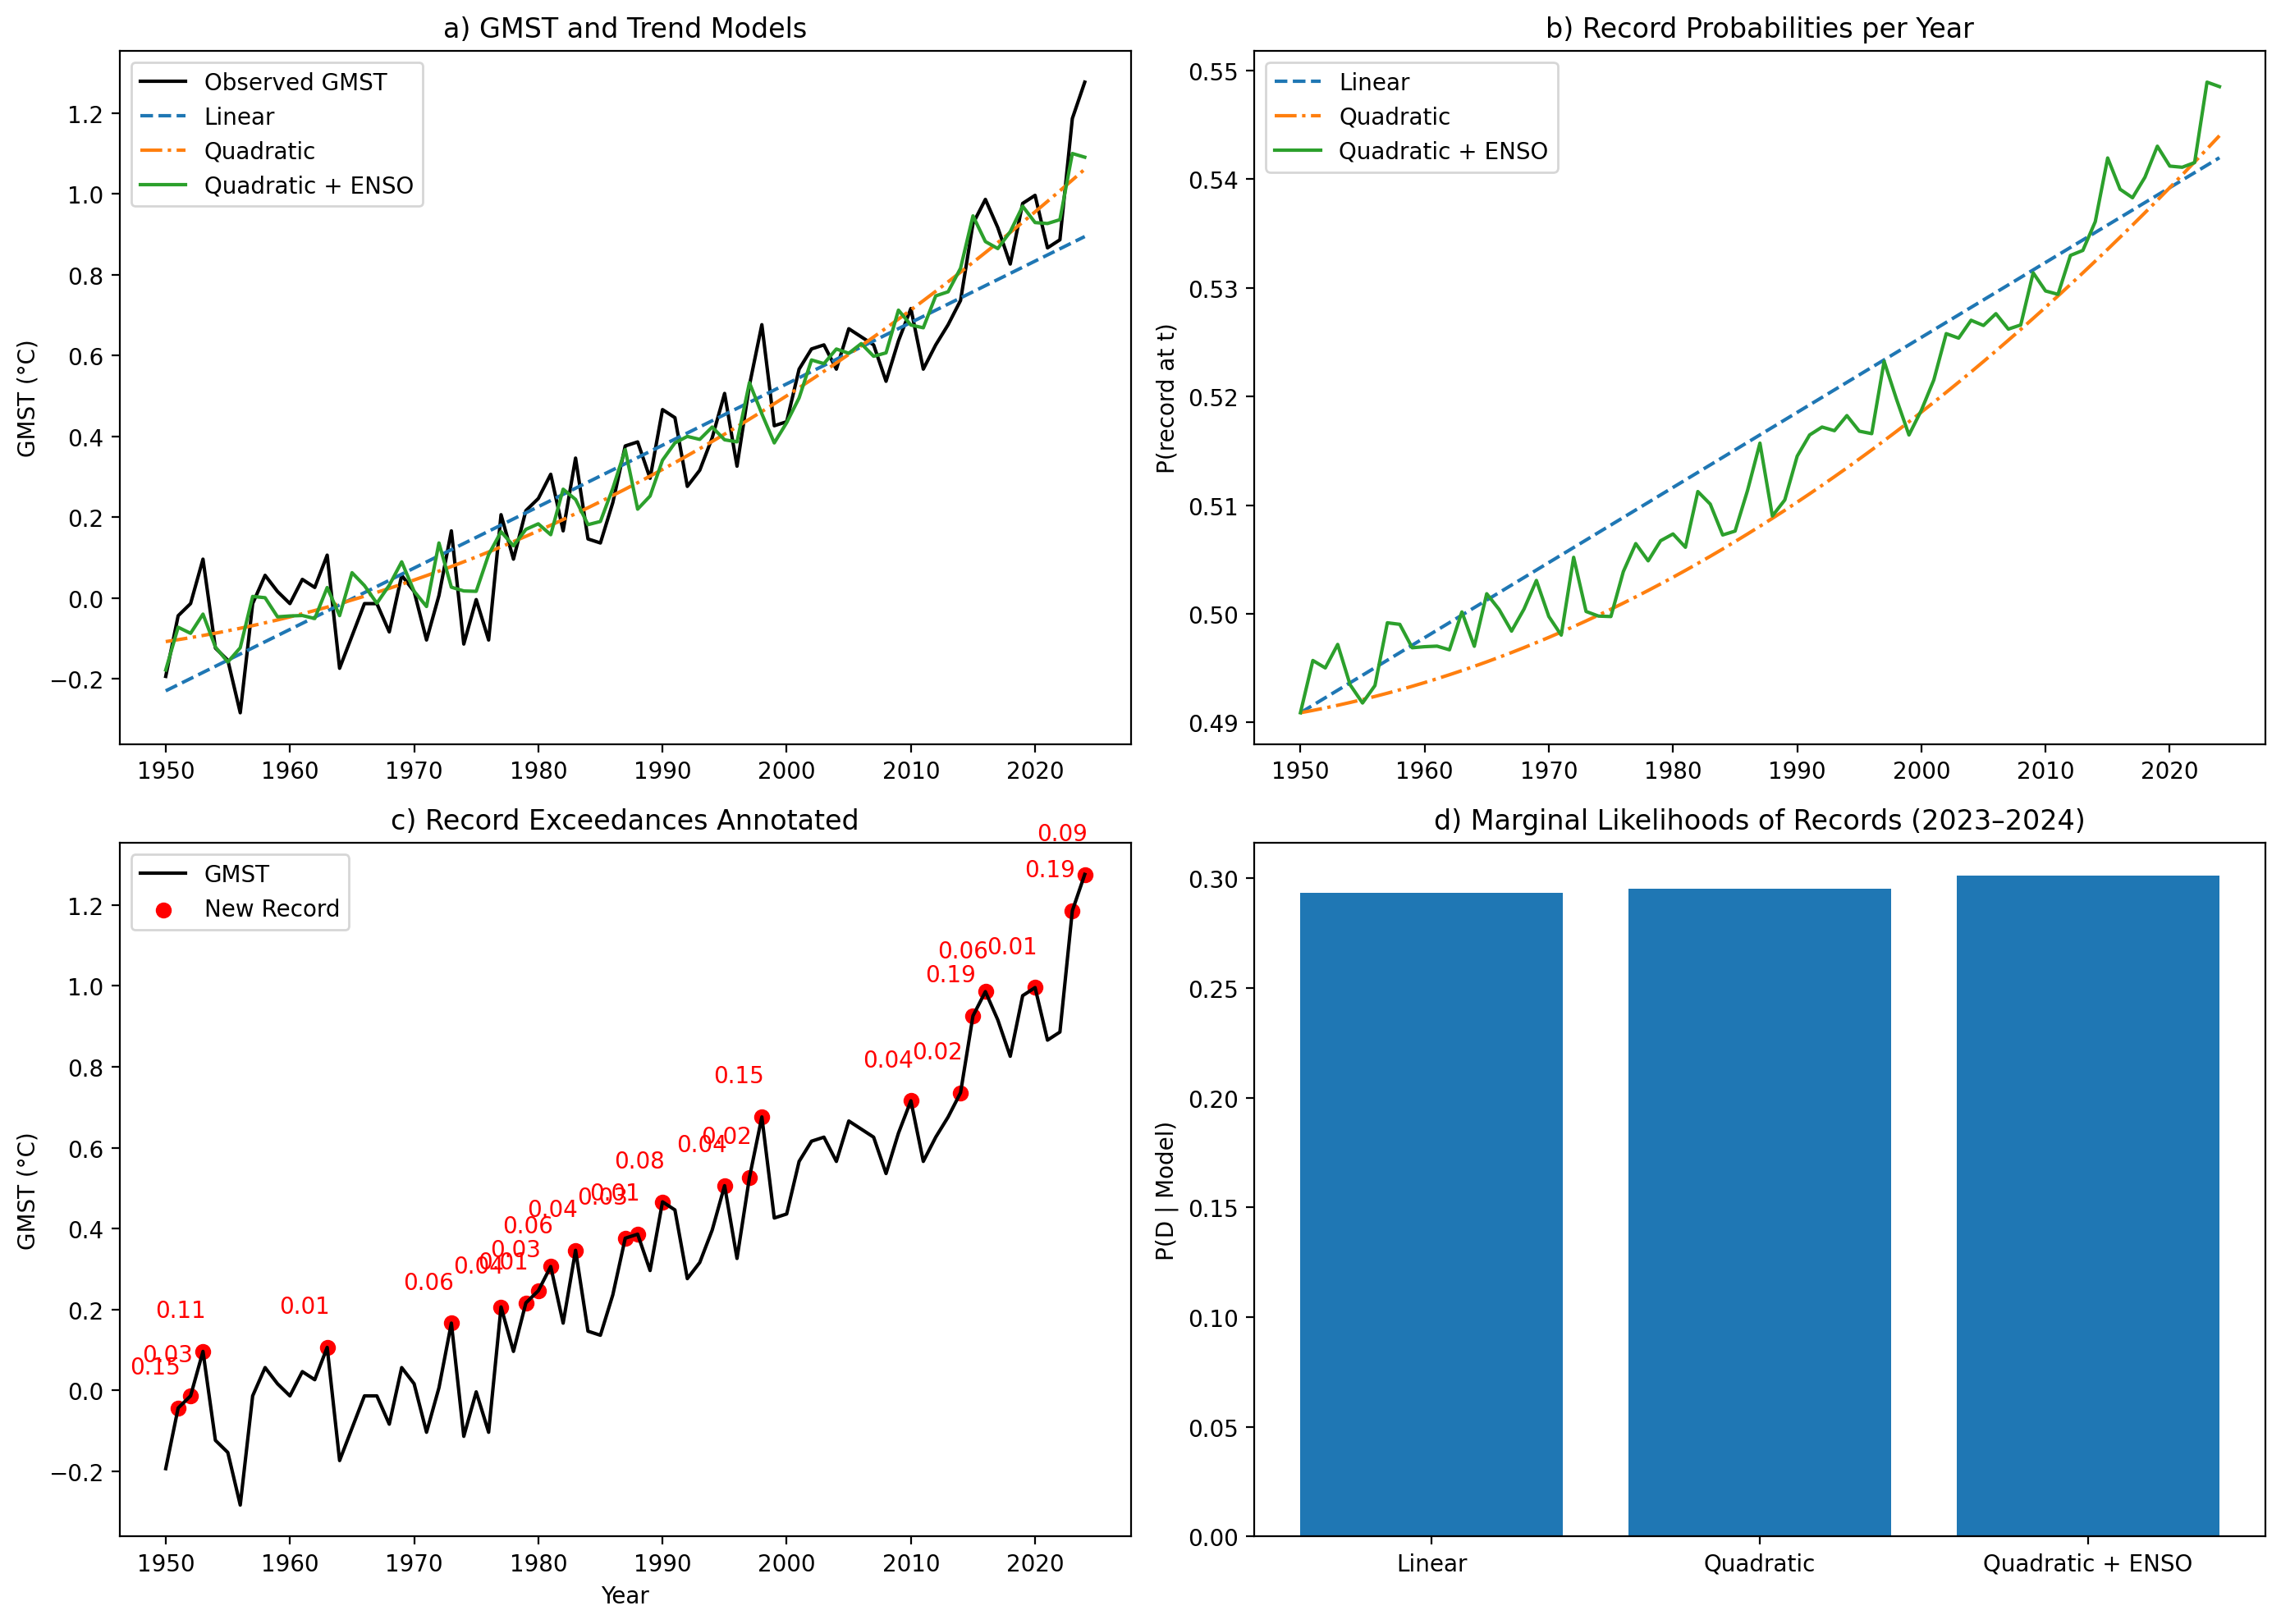

In [24]:


# Compute observed record flags
record_flags = y[1:] > np.maximum.accumulate(y[:-1])

# Last 2 record flags for 2023 and 2024
recent_record_flags = record_flags[-2:]

# Marginal likelihoods for each model for 2023 & 2024
def record_likelihood(P_record_model, flags):
    return np.prod([
        p if r else (1 - p)
        for p, r in zip(P_record_model[-2:], flags)
    ])

likelihoods = {
    "Linear": record_likelihood(P_tn_linear, recent_record_flags),
    "Quadratic": record_likelihood(P_tn_quadratic, recent_record_flags),
    "Quadratic + ENSO": record_likelihood(P_tn_quadratic_enso, recent_record_flags)
}

# --- Plot ---
fig, axs = plt.subplots(2, 2, figsize=(14, 10),dpi=200)
axs = axs.flatten()

# Panel A: GMST + Model Fits
axs[0].plot(t, y, label="Observed GMST", color="black")
axs[0].plot(t, yhat_lin, label="Linear", linestyle="--")
axs[0].plot(t, yhat_quad, label="Quadratic", linestyle="-.")
axs[0].plot(t, yhat_quad_enso, label="Quadratic + ENSO", linestyle="-")
axs[0].set_title("a) GMST and Trend Models")
axs[0].set_ylabel("GMST (°C)")
axs[0].legend()

# Panel B: Record Probabilities
axs[1].plot(t, P_tn_linear, label="Linear", linestyle="--")
axs[1].plot(t, P_tn_quadratic, label="Quadratic", linestyle="-.")
axs[1].plot(t, P_tn_quadratic_enso, label="Quadratic + ENSO", linestyle="-")
axs[1].set_title("b) Record Probabilities per Year")
axs[1].set_ylabel("P(record at t)")
axs[1].legend()

# Panel C: Record Events
axs[2].plot(t,y, label="GMST", color='black')
axs[2].scatter(t[1:][record_flags], y[1:][record_flags], color='red', label='New Record')
for i, txt in enumerate(record_exceedance):
    axs[2].annotate(f"{txt:.2f}", (t[1:][record_flags][i], y[1:][record_flags][i]), textcoords="offset points", xytext=(-10,15), ha='center', color='red')
axs[2].set_xlabel('Year')
axs[2].set_ylabel('GMST (°C)')
axs[2].set_title('c) Record Exceedances Annotated')
axs[2].legend()



# Panel D: Marginal Likelihood Comparison
axs[3].bar(likelihoods.keys(), likelihoods.values())
axs[3].set_title("d) Marginal Likelihoods of Records (2023–2024)")
axs[3].set_ylabel("P(D | Model)")

plt.tight_layout()
plt.show()


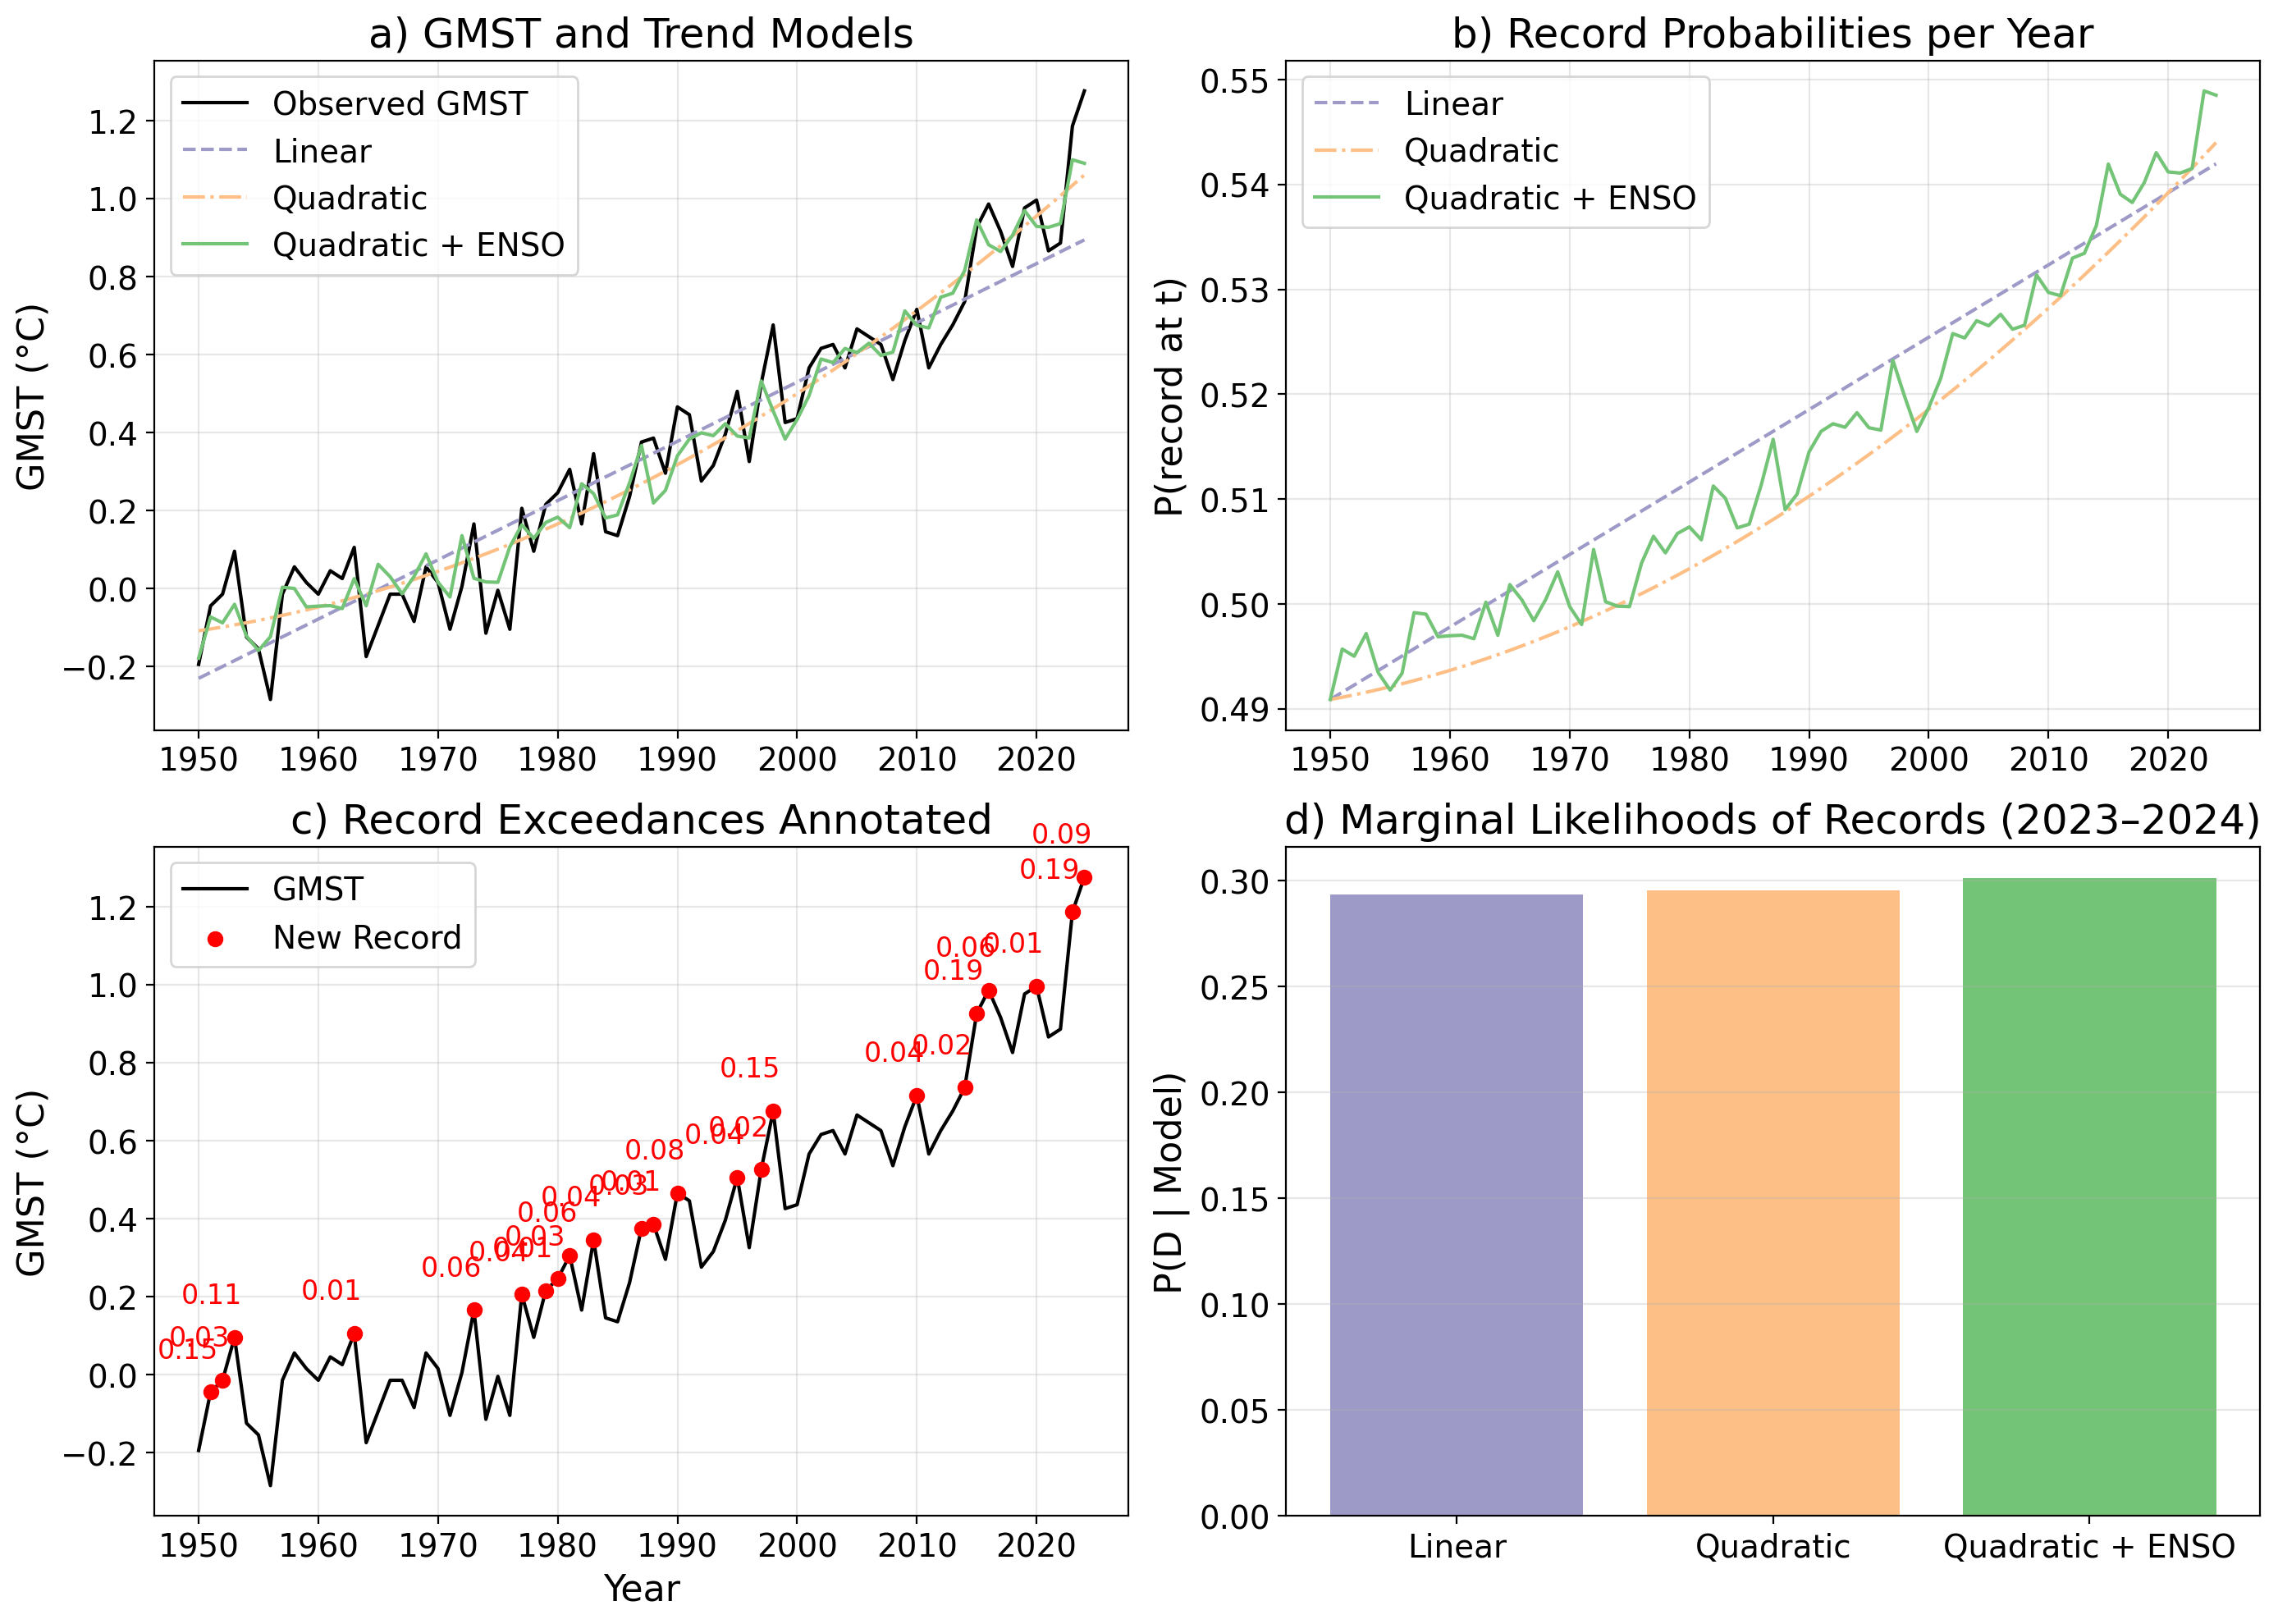

In [29]:


# === Font scaling ===
TITLE_FONTSIZE = 18
LABEL_FONTSIZE = 16
TICK_FONTSIZE = 14
LEGEND_FONTSIZE = 14
ANNOT_FONTSIZE = 12

# === Color setup ===
dark_oranges = sns.color_palette("Oranges", n_colors=15)[4:]
dark_purples = sns.color_palette("Purples", n_colors=9)[4:]
dark_greens  = sns.color_palette("Greens", n_colors=9)[4:]

COLORS = {
    "Linear": dark_purples[0],
    "Quadratic": dark_oranges[0],
    "Quadratic + ENSO": dark_greens[0],
    "GMST": "black",
    "Record": "red"
}

# --- Compute record flags ---
record_flags = y[1:] > np.maximum.accumulate(y[:-1])
recent_record_flags = record_flags[-2:]

def record_likelihood(P_record_model, flags):
    """Compute likelihood of observed record sequence given model probabilities."""
    return np.prod([p if r else (1 - p) for p, r in zip(P_record_model[-2:], flags)])

likelihoods = {
    "Linear": record_likelihood(P_tn_linear, recent_record_flags),
    "Quadratic": record_likelihood(P_tn_quadratic, recent_record_flags),
    "Quadratic + ENSO": record_likelihood(P_tn_quadratic_enso, recent_record_flags)
}

# === Figure ===
fig, axs = plt.subplots(2, 2, figsize=(14, 10), dpi=200)
axs = axs.flatten()

# === Panel A: GMST + Model Fits ===
axs[0].plot(t, y, label="Observed GMST", color=COLORS["GMST"])
axs[0].plot(t, yhat_lin, label="Linear", linestyle="--", color=COLORS["Linear"])
axs[0].plot(t, yhat_quad, label="Quadratic", linestyle="-.", color=COLORS["Quadratic"])
axs[0].plot(t, yhat_quad_enso, label="Quadratic + ENSO", linestyle="-", color=COLORS["Quadratic + ENSO"])
axs[0].set_title("a) GMST and Trend Models", fontsize=TITLE_FONTSIZE)
axs[0].set_ylabel("GMST (°C)", fontsize=LABEL_FONTSIZE)
axs[0].tick_params(axis='both', labelsize=TICK_FONTSIZE)
axs[0].legend(fontsize=LEGEND_FONTSIZE)
axs[0].grid(alpha=0.3)

# === Panel B: Record Probabilities per Year ===
axs[1].plot(t, P_tn_linear, label="Linear", linestyle="--", color=COLORS["Linear"])
axs[1].plot(t, P_tn_quadratic, label="Quadratic", linestyle="-.", color=COLORS["Quadratic"])
axs[1].plot(t, P_tn_quadratic_enso, label="Quadratic + ENSO", linestyle="-", color=COLORS["Quadratic + ENSO"])
axs[1].set_title("b) Record Probabilities per Year", fontsize=TITLE_FONTSIZE)
axs[1].set_ylabel("P(record at t)", fontsize=LABEL_FONTSIZE)
axs[1].tick_params(axis='both', labelsize=TICK_FONTSIZE)
axs[1].legend(fontsize=LEGEND_FONTSIZE)
axs[1].grid(alpha=0.3)

# === Panel C: Record Events Annotated ===
axs[2].plot(t, y, label="GMST", color=COLORS["GMST"])
axs[2].scatter(t[1:][record_flags], y[1:][record_flags],
               color=COLORS["Record"], label="New Record", zorder=5)
for i, txt in enumerate(record_exceedance):
    axs[2].annotate(f"{txt:.2f}",
                    (t[1:][record_flags][i], y[1:][record_flags][i]),
                    textcoords="offset points", xytext=(-10, 15),
                    ha='center', color=COLORS["Record"], fontsize=ANNOT_FONTSIZE)
axs[2].set_xlabel("Year", fontsize=LABEL_FONTSIZE)
axs[2].set_ylabel("GMST (°C)", fontsize=LABEL_FONTSIZE)
axs[2].set_title("c) Record Exceedances Annotated", fontsize=TITLE_FONTSIZE)
axs[2].tick_params(axis='both', labelsize=TICK_FONTSIZE)
axs[2].legend(fontsize=LEGEND_FONTSIZE)
axs[2].grid(alpha=0.3)

# === Panel D: Marginal Likelihood Comparison ===
axs[3].bar(
    likelihoods.keys(),
    likelihoods.values(),
    color=[COLORS["Linear"], COLORS["Quadratic"], COLORS["Quadratic + ENSO"]]
)
axs[3].set_title("d) Marginal Likelihoods of Records (2023–2024)", fontsize=TITLE_FONTSIZE)
axs[3].set_ylabel("P(D | Model)", fontsize=LABEL_FONTSIZE)
axs[3].tick_params(axis='both', labelsize=TICK_FONTSIZE)
axs[3].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()
